# Bitcoin Market Price Forecasting with PySpark
***

## Setting up a Spark runtime for Google Colab 
***

  ### 1. Installing Dependencies 
   ***

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.3.3/spark-2.3.3-bin-hadoop2.7.tgz
!tar xf spark-2.3.3-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install flask==0.12.2
!pip install flask-ngrok 
!pip install flask_cors


     |████████████████████████████████| 92kB 3.2MB/s 
  Found existing installation: Flask 1.0.3
    Uninstalling Flask-1.0.3:
      Successfully uninstalled Flask-1.0.3


### 2. Assigning Environment Variables
***

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.3-bin-hadoop2.7"
import findspark
findspark.init()

### 3. Launch a Spark Session with PySpark Library 
***

In [0]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

### 4. Import Utility/Data Science Libraries 
***

In [0]:
#General System Utilities
import sys
from datetime import datetime
import pickle

#Data Processing Libraries 
import numpy as np
import pandas as pd
from pandas import concat
import matplotlib.pyplot as plt
from fastai.tabular import *
import six

#Pyspark/SQL libs 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType, IntegerType, FloatType
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

#DS/DL Libs 
import sklearn
from sklearn.linear_model import LinearRegression as sklearnLR
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Problem Statement/Accessing the Data
***

### 1. The Problem Statement
***
Problem Type: Multivariate Timeseries Forecasting

### 2. Importing the Data File
***



In [0]:
func =  udf (lambda x: datetime.strptime(x, "%m/%d/%y"), DateType())
btc_data_df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('btc_data.csv')
btc_data_df = btc_data_df.withColumn('Date', func(col('Date')))
btc_data_df.take(1)

[Row(Date=datetime.date(2009, 1, 3), Coin Supply=50, Market Price (USD)=0.0, Market Cap (USD)=0.0, Trade Volume (USD)=0.0, Blockchain Size=0, Avg Block Sz (MB)=0.000285, Avg Txs/Block=1, Median Tx Confirm Time (Minutes)=0.0, Hash Rate (TH/s)=0.0, Mining Difficulty=1, Mining Revenue (USD)=0.0, Tx Fees (BTC)=0, Tx Fees (USD)=0.0, Cost/Tx %=0.0, Cost/Tx (USD)=0.0, N-Unique Addresses=1, N-Confirmed Txs/Day=1, N-Txs=1, N-Txs (Excluding Top 100)=1, Tx Output Value (BTC)=50, Total Est Tx Value (BTC)=0, Total Est Tx Value (USD)=0.0)]

### 3. Exploring the Data Structure 
***

In [0]:
btc_data_df.cache()
btc_data_df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Coin Supply: integer (nullable = true)
 |-- Market Price (USD): double (nullable = true)
 |-- Market Cap (USD): double (nullable = true)
 |-- Trade Volume (USD): double (nullable = true)
 |-- Blockchain Size: integer (nullable = true)
 |-- Avg Block Sz (MB): double (nullable = true)
 |-- Avg Txs/Block: integer (nullable = true)
 |-- Median Tx Confirm Time (Minutes): double (nullable = true)
 |-- Hash Rate (TH/s): double (nullable = true)
 |-- Mining Difficulty: long (nullable = true)
 |-- Mining Revenue (USD): double (nullable = true)
 |-- Tx Fees (BTC): integer (nullable = true)
 |-- Tx Fees (USD): double (nullable = true)
 |-- Cost/Tx %: double (nullable = true)
 |-- Cost/Tx (USD): double (nullable = true)
 |-- N-Unique Addresses: integer (nullable = true)
 |-- N-Confirmed Txs/Day: integer (nullable = true)
 |-- N-Txs: integer (nullable = true)
 |-- N-Txs (Excluding Top 100): integer (nullable = true)
 |-- Tx Output Value (BTC): integer (nu

## Feature Engineering
***



### 1. Augmenting Date
***

**1a. Unroll Date with Fast.ai Tabular Model**

In [0]:
expanded_btc_df = add_datepart(btc_data_df.toPandas(), "Date", drop=False)
expanded_btc_df = spark.createDataFrame(expanded_btc_df)
expanded_btc_df = expanded_btc_df.fillna(0)
expanded_btc_df.cache()
expanded_btc_df.printSchema()


root
 |-- Date: timestamp (nullable = true)
 |-- Coin Supply: long (nullable = true)
 |-- Market Price (USD): double (nullable = false)
 |-- Market Cap (USD): double (nullable = false)
 |-- Trade Volume (USD): double (nullable = false)
 |-- Blockchain Size: long (nullable = true)
 |-- Avg Block Sz (MB): double (nullable = false)
 |-- Avg Txs/Block: long (nullable = true)
 |-- Median Tx Confirm Time (Minutes): double (nullable = false)
 |-- Hash Rate (TH/s): double (nullable = false)
 |-- Mining Difficulty: long (nullable = true)
 |-- Mining Revenue (USD): double (nullable = false)
 |-- Tx Fees (BTC): long (nullable = true)
 |-- Tx Fees (USD): double (nullable = false)
 |-- Cost/Tx %: double (nullable = false)
 |-- Cost/Tx (USD): double (nullable = false)
 |-- N-Unique Addresses: double (nullable = false)
 |-- N-Confirmed Txs/Day: long (nullable = true)
 |-- N-Txs: long (nullable = true)
 |-- N-Txs (Excluding Top 100): long (nullable = true)
 |-- Tx Output Value (BTC): long (nullable = 

### 2. Categorize Features
***

**2a. Categorize**

In [0]:
#Dependent Var
dep_var = 'Market Price (USD)'


#For quick access 
all_columns = expanded_btc_df.columns


#Categorical
categ_columns = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']

#Continuous 
cont_columns = ['Coin Supply',	'Market Cap (USD)',	'Trade Volume (USD)',	'Blockchain Size',	'Avg Block Sz (MB)',	
                'Avg Txs/Block',	'Median Tx Confirm Time (Minutes)', 'Hash Rate (TH/s)',	'Mining Difficulty',	
                'Mining Revenue (USD)',	'Tx Fees (BTC)', 'Tx Fees (USD)',	'Cost/Tx %', 'Elapsed',
                'Cost/Tx (USD)',	'N-Unique Addresses',	'N-Confirmed Txs/Day',	'N-Txs',	'N-Txs (Excluding Top 100)',
                'Tx Output Value (BTC)','Total Est Tx Value (BTC)','Total Est Tx Value (USD)']


tf_columns=['Is_month_end', 'Is_month_start',
        'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']


**2b. Reformat True/False to Binary Scale**

In [0]:
for col_name in tf_columns:
    expanded_btc_df = expanded_btc_df.withColumn(col_name, col(col_name).cast('int'))  

print("Sample of a binary column transformed: ")    
expanded_btc_df.toPandas().Is_month_end[:10]

Sample of a binary column transformed: 


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: Is_month_end, dtype: int32

### 3. Statistical Analysis of DataFrame
****


**3a. Reset Index of Time Series to Date**

In [0]:
expanded_btc_df.toPandas().index = expanded_btc_df.toPandas()['Date']


**3b. Tabulate Statitcal Moments**

In [0]:
pd.set_option('display.max_colwidth', -1)
expanded_btc_df.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Coin Supply,1268.0,1.107565e+07,5.450896e+06,5.000000e+01,7.029625e+06,1.253229e+07,1.594668e+07,1.773586e+07
Market Price (USD),1268.0,1.453684e+03,2.853359e+03,0.000000e+00,4.765000e+00,2.389950e+02,7.835575e+02,1.928979e+04
Market Cap (USD),1268.0,2.426743e+10,4.858195e+10,0.000000e+00,3.736004e+07,3.424074e+09,1.142555e+10,3.230718e+11
Trade Volume (USD),1268.0,1.116639e+08,3.086776e+08,0.000000e+00,1.184391e+05,1.017620e+07,4.639431e+07,3.800433e+09
Blockchain Size,1268.0,5.067764e+04,6.560066e+04,0.000000e+00,3.200000e+02,1.611100e+04,8.730225e+04,2.213460e+05
Avg Block Sz (MB),1268.0,3.879263e-01,3.951660e-01,0.000000e+00,1.768084e-02,2.140232e-01,7.804961e-01,1.261405e+00
Avg Txs/Block,1268.0,7.322744e+02,7.617208e+02,1.000000e+00,3.900000e+01,3.895000e+02,1.394250e+03,2.763000e+03
Median Tx Confirm Time (Minutes),1268.0,6.968825e+00,5.068992e+00,0.000000e+00,0.000000e+00,7.780000e+00,9.950000e+00,2.895000e+01
Hash Rate (TH/s),1268.0,6.162973e+06,1.397446e+07,0.000000e+00,8.670000e+00,3.644571e+04,1.819071e+06,6.008953e+07
Mining Difficulty,1268.0,8.334912e+11,1.895858e+12,0.000000e+00,1.192498e+06,4.250218e+09,2.538687e+11,7.459681e+12


**3c. Drop Date to Explore Feature Correlation**

In [0]:
btc_no_date = spark.createDataFrame(expanded_btc_df.toPandas().drop('Date', axis=1))
btc_no_date.toPandas().index = expanded_btc_df.toPandas().index
btc_no_date.show(5)

+-----------+------------------+----------------+------------------+---------------+-----------------+-------------+--------------------------------+----------------+-----------------+--------------------+-------------+-------------+---------+-------------+------------------+-------------------+-----+-------------------------+---------------------+------------------------+------------------------+----+-----+----+---+---------+---------+------------+--------------+--------------+----------------+-----------+-------------+----------+
|Coin Supply|Market Price (USD)|Market Cap (USD)|Trade Volume (USD)|Blockchain Size|Avg Block Sz (MB)|Avg Txs/Block|Median Tx Confirm Time (Minutes)|Hash Rate (TH/s)|Mining Difficulty|Mining Revenue (USD)|Tx Fees (BTC)|Tx Fees (USD)|Cost/Tx %|Cost/Tx (USD)|N-Unique Addresses|N-Confirmed Txs/Day|N-Txs|N-Txs (Excluding Top 100)|Tx Output Value (BTC)|Total Est Tx Value (BTC)|Total Est Tx Value (USD)|Year|Month|Week|Day|Dayofweek|Dayofyear|Is_month_end|Is_month_

### 4.Feature Correlation
***

**4a. Get Correlation Matrix for all Values**

In [0]:
cor = btc_no_date.toPandas().corr().abs()


**4b. Correlation b/w Market Price and Continuous Features:**

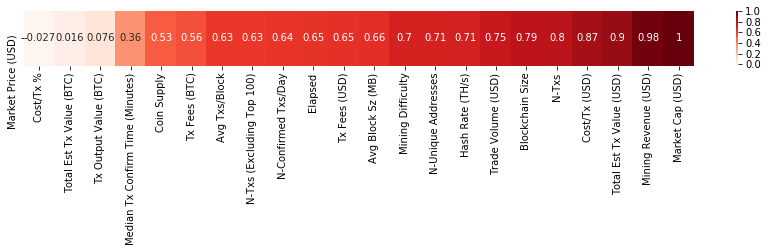

In [0]:
cont_df = btc_no_date.toPandas()[cont_columns]
cont_df[dep_var] = btc_no_date.toPandas()[dep_var]
cont_corr_df = cont_df.corr()
plt.figure(figsize=(15,1))
sns.heatmap(cont_corr_df.sort_values(by=dep_var, axis=1).drop(dep_var, axis=1).tail(1), annot=True, cmap=plt.cm.Reds)
plt.show()

**4c. Feature Correlation with Binary Features:**

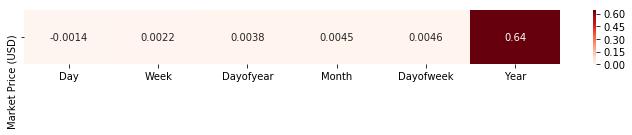

In [0]:
#Get correlations b/w Dep. Var and Continuous Cols
cat_df = btc_no_date[categ_columns].toPandas()
cat_df[dep_var]=btc_no_date.toPandas()[dep_var]
cat_corr_df = cat_df.corr()
plt.figure(figsize=(12,1))
sns.heatmap(cat_corr_df.sort_values(by=dep_var, axis=1).drop(dep_var, axis=1).tail(1), annot=True, cmap=plt.cm.Reds)
plt.show()


**4d: Correlation b/w Market Price Categorical/Binary Features:**

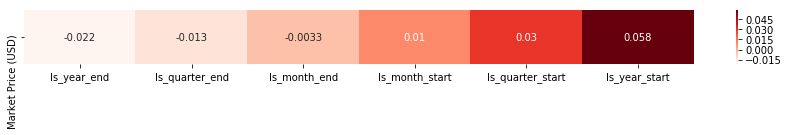

In [0]:
bi_df = btc_no_date.toPandas()[tf_columns]
bi_df[dep_var] = btc_no_date.toPandas()[dep_var]
bi_corr_df = bi_df.corr()
plt.figure(figsize=(15,1))
sns.heatmap(bi_corr_df.sort_values(by=dep_var, axis=1).drop(dep_var, axis=1).tail(1), annot=True, cmap=plt.cm.Reds)
plt.show()

### 5. Dropping Highly Correlated Features 
***

**5a. Defining Correlation Output Variable:**

In [0]:
#Correlation with output variable
cor_target = cor[dep_var]

**5b. Identifying Features Highly Correlated with Target and Other Features:**

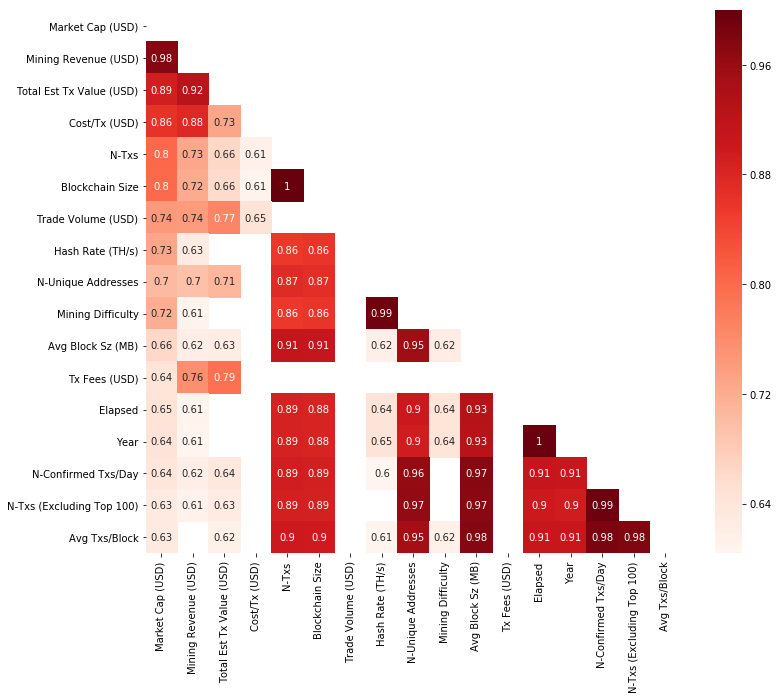

(['Market Cap (USD)',
  'Mining Revenue (USD)',
  'Total Est Tx Value (USD)',
  'Cost/Tx (USD)',
  'N-Txs',
  'Blockchain Size',
  'Trade Volume (USD)',
  'Hash Rate (TH/s)',
  'N-Unique Addresses',
  'Mining Difficulty',
  'Avg Block Sz (MB)',
  'Tx Fees (USD)',
  'Elapsed',
  'Year',
  'N-Confirmed Txs/Day',
  'N-Txs (Excluding Top 100)',
  'Avg Txs/Block'],
 None)

In [0]:
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.6]

rel_df = relevant_features.to_frame() #.transpose()
rel_df = rel_df.sort_values(dep_var, ascending=False)
rel_columns = rel_df[1:].index.values.tolist()
rel_corr_df = btc_no_date[rel_columns].toPandas().corr()

plt.figure(figsize=(12,10))
mask = np.zeros_like(rel_corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(rel_corr_df[rel_corr_df>.6], annot=True, cmap=plt.cm.Reds, mask=mask)
rel_columns, plt.show()



**5c. Reducing Dimensionality of Correlation Matrix:**

In [0]:
def dimentionalize_corr_matrix(cor_df, upper_bound=0.95):
  upper = cor_df.where(np.triu(np.ones(cor_df.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper.columns if any(upper[column] > upper_bound)]
  rel_df_clean = cor_df.drop(cor_df[to_drop], axis=0)
  rel_df_clean =  rel_df_clean.drop( rel_df_clean[to_drop], axis=1)
  return rel_df_clean
  

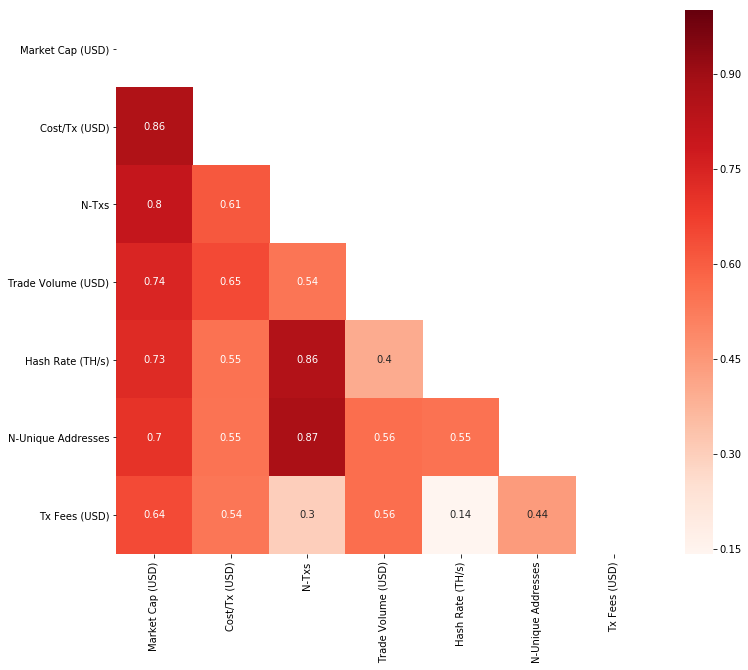

(['Market Cap (USD)',
  'Cost/Tx (USD)',
  'N-Txs',
  'Trade Volume (USD)',
  'Hash Rate (TH/s)',
  'N-Unique Addresses',
  'Tx Fees (USD)'],
 None)

In [0]:
rel_df_clean = dimentionalize_corr_matrix(rel_corr_df, .9)
rel_columns = rel_df_clean.columns.tolist()

plt.figure(figsize=(12,10))
mask = np.zeros_like(rel_df_clean, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(rel_df_clean, annot=True, cmap=plt.cm.Reds, mask=mask)
rel_columns, plt.show()


**5d. Using Sklearn Feature Estimator:**

In [0]:
model = sklearnLR()
rfe = RFE(model, 7)
y = btc_no_date.toPandas()[dep_var].tolist()

In [0]:
X_rfe = rfe.fit_transform(btc_no_date.toPandas().drop(dep_var, axis=1), y)
model.fit(X_rfe, y)
temp = pd.Series(rfe.support_,index = btc_no_date.toPandas().drop(dep_var, axis=1).columns)
selected_features_rfe = temp[temp==True].index.values.tolist()
print(selected_features_rfe)

['Avg Block Sz (MB)', 'Cost/Tx (USD)', 'Year', 'Is_month_end', 'Is_month_start', 'Is_quarter_start', 'Is_year_start']


## Creating a Machine Learning Pipeline
***

### 1. Assemble the Featurizers
***

In [0]:
feature_minus_dep = cont_columns + categ_columns + tf_columns 


vectorAssembler = VectorAssembler(
    inputCols = feature_minus_dep                                                                                                                                                                                                                               , 
    outputCol = 'features')


vectorAssembler2 = VectorAssembler(
    inputCols = rel_columns                                                                                                                                                                                                                           , 
    outputCol = 'features')

vectorAssembler3 = VectorAssembler(
    inputCols = selected_features_rfe                                                                                                                                                                                                                         , 
    outputCol = 'features')


### 2. Transform the Data
***

In [0]:
#All columns featurized 
v_btc_no_date_df = vectorAssembler.transform(btc_no_date)
v_btc_no_date_df = v_btc_no_date_df.select(['features', dep_var])
v_btc_no_date_df.show(3)

#Relevant columns featurized 
v_rel_btc_no_date_df = vectorAssembler2.transform(btc_no_date)
v_rel_btc_no_date_df = v_rel_btc_no_date_df.select(['features', dep_var])
v_rel_btc_no_date_df.show(3)

#RFE-selected columns featurized 
v_sel_btc_no_date_df = vectorAssembler3.transform(btc_no_date)
v_sel_btc_no_date_df = v_sel_btc_no_date_df.select(['features', dep_var])
v_sel_btc_no_date_df.show(3)

+--------------------+------------------+
|            features|Market Price (USD)|
+--------------------+------------------+
|(34,[0,4,5,8,13,1...|               0.0|
|(34,[0,5,13,17,22...|               0.0|
|(34,[0,4,5,8,13,1...|               0.0|
+--------------------+------------------+
only showing top 3 rows

+--------------------+------------------+
|            features|Market Price (USD)|
+--------------------+------------------+
| (7,[2,5],[1.0,1.0])|               0.0|
|       (7,[2],[1.0])|               0.0|
|(7,[2,5],[15.0,14...|               0.0|
+--------------------+------------------+
only showing top 3 rows

+--------------------+------------------+
|            features|Market Price (USD)|
+--------------------+------------------+
|(7,[0,2],[2.85E-4...|               0.0|
|    (7,[2],[2009.0])|               0.0|
|(7,[0,2],[2.15E-4...|               0.0|
+--------------------+------------------+
only showing top 3 rows



### 3. Partition the Data for Training and Testing
****

In [0]:
def regression_data_builder(spark_df, part_index):
  train_df = spark.createDataFrame(spark_df.toPandas()[:part_index])
  valid_df = spark.createDataFrame(spark_df.toPandas()[part_index:])
  return train_df, valid_df
  

In [0]:
v_btc_no_date_df.index = expanded_btc_df.toPandas().index
v_rel_btc_no_date_df.index = expanded_btc_df.toPandas().index
v_sel_btc_no_date_df.index = expanded_btc_df.toPandas().index

valid_index =  int(v_btc_no_date_df.toPandas().shape[0] * .8)

btc_train_df, btc_test_df = regression_data_builder(v_btc_no_date_df, valid_index)
btc_rel_train_df, btc_rel_test_df = regression_data_builder(v_rel_btc_no_date_df, valid_index) 
btc_sel_train_df, btc_sel_test_df = regression_data_builder(v_sel_btc_no_date_df, valid_index)


print(btc_train_df.toPandas().shape, btc_test_df.toPandas().shape)
print(btc_rel_train_df.toPandas().shape, btc_rel_test_df.toPandas().shape)
print(btc_sel_train_df.toPandas().shape, btc_sel_test_df.toPandas().shape)

(1014, 2) (254, 2)
(1014, 2) (254, 2)
(1014, 2) (254, 2)


### 4. Fit the Linear Regression Model
***

In [0]:
lr = LinearRegression(featuresCol="features", labelCol=dep_var, maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model_reg = lr.fit(btc_train_df)
lr_model_rel = lr.fit(btc_rel_train_df)
lr_model_sel = lr.fit(btc_sel_train_df)

print("Coefficients for All Features: " + str(lr_model_reg.coefficients))
print("Intercept for All Features: " + str(lr_model_reg.intercept))
print("")

print("Coefficients for Relevant Features: " + str(lr_model_rel.coefficients))
print("Intercept for Relevant Features: " + str(lr_model_rel.intercept))
print("")

print("Coefficients for RFE-selected Features: " + str(lr_model_sel.coefficients))
print("Intercept for RFE-slected Features: " + str(lr_model_sel.intercept))
print("")

Coefficients for All Features: [0.0,1.7078139108250146e-08,-2.115554614418536e-07,0.0004270044187641544,6.239893267828199,0.003429979696709965,-0.1434931587935179,3.066098343433062e-05,2.5701103183543495e-10,7.007553729014436e-05,-0.05481848606547113,0.0008382622974685414,0.0003338822469139472,0.0,5.562776100847936,5.309036088163017e-05,2.821856382204285e-05,2.5255698926210144e-07,7.334724592339215e-05,-3.091833754317754e-06,-1.549978710017697e-05,3.3897505042728797e-07,0.0,0.4534718197879544,0.18513190826940504,-0.15089049498989474,0.0,0.014526612291111981,0.0,-7.977852162976672,14.08491910139596,-5.420856333960018,2.090112797883247,-86.15968602596286]
Intercept for All Features: -19.33146424383884

Coefficients for Relevant Features: [3.520668545570556e-08,7.114362319325985,6.697158151153806e-07,-2.2195010547200938e-07,3.764977706010813e-05,0.0001799559016344142,0.0006653098962939075]
Intercept for Relevant Features: -26.249108777368917

Coefficients for RFE-selected Features: [970.7

### 5. Test the Models 
***

In [0]:
btc_preds_reg = lr_model_reg.transform(btc_test_df) 
btc_preds_rel = lr_model_rel.transform(btc_rel_test_df) 
btc_preds_sel = lr_model_sel.transform(btc_sel_test_df) 
btc_preds_reg.show(20), btc_preds_rel.show(20), btc_preds_sel.show(20)

+--------------------+------------------+------------------+
|            features|Market Price (USD)|        prediction|
+--------------------+------------------+------------------+
|[1.6308863E7,2.45...|           1507.58|1463.2390814931025|
|[1.6314675E7,2.54...|           1560.41| 1639.105826746718|
|[1.632095E7,2.809...|           1721.28|1862.6267214997497|
|[1.6326413E7,2.80...|           1720.48|1856.5202261453378|
|[1.6332563E7,2.81...|           1723.13|1935.1797181170093|
|[1.6337925E7,3.10...|           1899.08| 2095.660884568126|
|[1.6343875E7,3.34...|           2046.53| 2110.686158233822|
|[1.6349725E7,3.88...|           2379.19|2814.3045540538737|
|[1.6355775E7,3.29...|           2014.05|2522.8320515688324|
|[1.6361963E7,3.66...|           2239.21|2958.5817030052153|
|[1.6367963E7,4.00...|           2446.14| 2781.028238813789|
|[1.6374425E7,4.41...|           2698.31| 3113.449397548964|
|[1.6380438E7,4.57...|            2793.0| 3273.029556826837|
|[1.6385913E7,4.85...|  

(None, None, None)

### 6. Analyze the Results
***

**6a. Review Performance Metrics**

In [0]:
#Training Summaries for the 3 Models 
trainingSummary_reg = lr_model_reg.summary
trainingSummary_rel = lr_model_rel.summary
trainingSummary_sel = lr_model_sel.summary

#Performance Metrics for model with all-features
print("RMSE w/ All Features: %f" % trainingSummary_reg.rootMeanSquaredError)
print("r2(All Features): %f" % trainingSummary_reg.r2)
print('')

#Performance Metrics for model with relevant features 
print("RMSE w/ Relevant Features: %f" % trainingSummary_rel.rootMeanSquaredError)
print("r2 (Relevant Features): %f" % trainingSummary_rel.r2)
print('')

#Performance Metrics for model with RFE-selected features 
print("RMSE w/ RFE Features: %f" % trainingSummary_sel.rootMeanSquaredError)
print("r2 (RFE Features): %f" % trainingSummary_sel.r2)


RMSE w/ All Features: 37.155439
r2(All Features): 0.984842

RMSE w/ Relevant Features: 35.631238
r2 (Relevant Features): 0.986060

RMSE w/ RFE Features: 106.434752
r2 (RFE Features): 0.875614


**6b. Compile Data with Predictions for Visualization**

In [0]:
#all features 
pred_reg_df = pd.DataFrame(expanded_btc_df.toPandas())
pred_reg_df['Date'] = pd.to_datetime(pred_reg_df['Date'])
pred_reg_df = pred_reg_df.set_index('Date')
pred_reg_train_df = pred_reg_df[:valid_index]
pred_reg_test_df = pred_reg_df[valid_index:]
pred_reg_test_df = pred_reg_test_df.assign(Predictions = btc_preds_reg.toPandas()['prediction'].tolist())

#relevant features 
pred_rel_df = pd.DataFrame(expanded_btc_df.toPandas()[[dep_var, 'Date'] + rel_columns ])
pred_rel_df['Date'] = pd.to_datetime(pred_rel_df['Date'])
pred_rel_df = pred_rel_df.set_index('Date')
pred_rel_train_df = pred_rel_df[:valid_index]
pred_rel_test_df = pred_rel_df[valid_index:]
pred_rel_test_df = pred_rel_test_df.assign(Predictions = btc_preds_rel.toPandas()['prediction'].tolist())

#RFE-selected features 
pred_sel_df = pd.DataFrame(expanded_btc_df.toPandas()[[dep_var, 'Date'] + selected_features_rfe])
pred_sel_df['Date'] = pd.to_datetime(pred_sel_df['Date'])
pred_sel_df = pred_sel_df.set_index('Date')
pred_sel_train_df = pred_sel_df[:valid_index]
pred_sel_test_df = pred_sel_df[valid_index:]
pred_sel_test_df = pred_sel_test_df.assign(Predictions = btc_preds_sel.toPandas()['prediction'].tolist())




**6c. Plot Actual Dailly Market Prices against Predicted Prices**

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


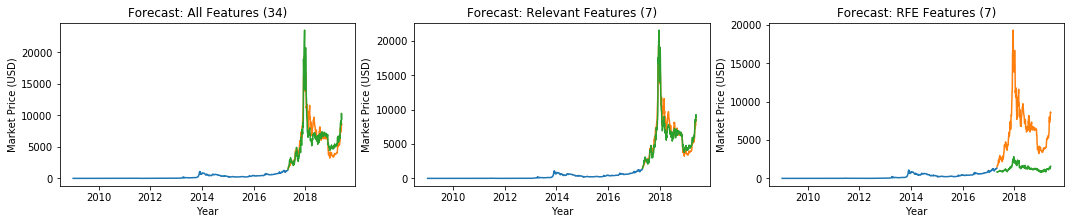

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3))

ax[0].set_title('Forecast: All Features (34)')
ax[0].set_ylabel(dep_var)
ax[0].set_xlabel('Year')
ax[0].plot(pred_reg_train_df[dep_var])
ax[0].plot(pred_reg_test_df[[dep_var, 'Predictions']])
    
    
ax[1].set_title('Forecast: Relevant Features (7)')
ax[1].set_ylabel(dep_var)
ax[1].set_xlabel('Year')
ax[1].plot(pred_rel_train_df[dep_var])
ax[1].plot(pred_rel_test_df[[dep_var, 'Predictions']])
    
  
ax[2].set_title('Forecast: RFE Features (7)')
ax[2].set_ylabel(dep_var)
ax[2].set_xlabel('Year')
ax[2].plot(pred_sel_train_df[dep_var])
ax[2].plot(pred_sel_test_df[[dep_var, 'Predictions']])